# Generating Text with an RNN

In [1]:
# !pip install --ignore-installed unidecode
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [3]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [4]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [5]:
chunk_len = 200
# chunk_len = 300

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

worst of words.

IAGO:
Good my lord, pardon me:
Though I am bound to every act of duty,
I am not bound to that all slaves are free to.
Utter my thoughts? Why, say they are vile and false;
As where's th


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [7]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [8]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [9]:
batch_size = 100
n_epochs = 5000
hidden_size = 200
n_layers = 2
learning_rate = 0.001
model_type = 'rnn'
print_every = 100
plot_every = 100


In [10]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [11]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = 0
    batch_size = input.size(0)
    chunk_len = input.size(1)
    hidden = rnn.init_hidden(batch_size)
    rnn.zero_grad()
    for cur_chunk in range(chunk_len):
        output, hidden = rnn(input[:, cur_chunk], hidden)
        loss += criterion(output.view(batch_size, -1), target[:, cur_chunk])

    loss.backward()
    optimizer.step()
    return (loss.data[0]/chunk_len) 

In [12]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# Adding scheduler for learning rate descent
# scheduler = torch.optim.lr_scheduler.StepLR(rnn_optimizer, step_size=500, gamma=0.77)

criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
#     scheduler.step()
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 20s (100 2%) train loss: 2.0957, test_loss: 2.1101]
Whince to to loed,
That in to efare fort your the of with nok but; thet he thou siunt or well a be the 

 42s (200 4%) train loss: 1.8665, test_loss: 1.8972]
Whach thy with that loud lit in a, as to him a palice?
To him proan's a madies:
Doim do not.

ORING
Ma 

 2s (300 6%) train loss: 1.7656, test_loss: 1.8012]
Why, Grows amporty at
at's exfirds, old I an with though grod beat they hath as but as my garoods me y 

 23s (400 8%) train loss: 1.6941, test_loss: 1.7426]
Whom I
hear's vucan of living.

GERAND:
Come, when the deaky here barred my down
That and I ome know a 

 46s (500 10%) train loss: 1.6538, test_loss: 1.6836]
Why: I less he hath so makes, ride am water and present fortenes'd, no profition disonard of his comes 

 8s (600 12%) train loss: 1.5941, test_loss: 1.6409]
What you between of it.

EDRONICUS:
I will never remember him,
And I do neger in the littless promised 

 31s (700 14%) train loss: 1.5911, test_loss: 1.6189

In [13]:
# save network
torch.save(rnn.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

50


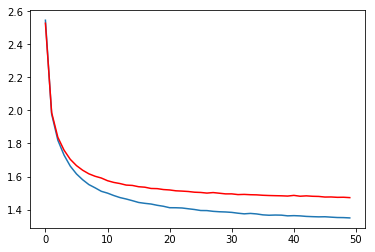

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
print(len(all_losses))
plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [15]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

Thou shalt be much to thee, Cain, such action to the death.

JULIET:
There now my master
Made him better to thee in the ring:
Adermen, let not this comes how their own age
Stands to decains the senses
With amiss.

LUCIANA:
There's not in all here:
The rich entertainted her stand upon a followers,
And show his art death; and all dark thou calm, that you are plays,
The tremble in my coloers still.

PRINCE HENRY:
The prasking very next dream, sir.

SIR, I think to longer made me well: speak the next of the death-day. But is the gods that begin my life.

EDGAR:
Here comes Ford is wronged limberland,
Upon this talk of that song!

GOBBO:
This doth must be happiness,
From her than to granted of me.

ANTIPO:
Thou dost news straight braggar in his courteous counce of brothers,
Troth, you see no doubt, he is, of the wind to hear thy brothers in commend her self. What, can you shall be say in a present;
We can have lose say without thee against her.

YORK:
I have shines of one hand of the lates. 

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.